In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn==1.3.0
!pip install torch
!pip install torchvision
!pip install seaborn
!pip install numpy
!pip install opencv-python
!pip install scikit-image
!pip install tqdm
!pip install joblib
!pip install scipy

In [2]:
import os
import pickle as pk
from itertools import product

import pandas as pd
from IPython.display import Image, display
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from src.data.elpv_reader import load_dataset
from src.data.preprocessing.mobilenetv2 import get_processed_data_loaders
from src.data.preprocessing.preprocess import Image as Preprocess
from src.models.eigencell.eigencell import EigenCell
from src.models.mobilenetv2.model_with_mobilenetv2_and_Kmeans import (
    get_solar_cell_defect_detector,
)
from src.models.mobilenetv2.testing import evaluate_detector_on_test_data
from src.utils.results_helper import map_label_to_probability
from src.visualization.visualize import (
    show_image,
    show_metrics,
    visualize_images_by_type_and_proba,
)
from src.visualization.visualize_results import plot_metrics

# Model: Mobilenetv2 with Kmeans classifier

The proposed approach consists of two phases.

The first phase is based on MobileNetv2 and Kmeans. This phase’s objective was to perform data training. It finds the clusters of solar cells, constructs a detection model that can identify the defective solar cell for each cluster of cells and builds a classifier model of the solar cell image of the constructed clusters, which helps overcome the confusion between the different cell shapes and increases the detection accuracy.

The second phase uses the constructed Kmeans classifier to classify the cell image to the cluster label that has the closest set of solar images. Then, it uses the assigned cluster’s constructed detection model to identify the defective solar cell.

The flow looks like this

<img src="data/model_architectures/mobilenetv2_with_kmeans_flow.png" width="1000" height="300">


__The first phase is the training phase and is as follows__

__Model1__: This is a modified MobileNetV2 model. The first convolutional layer is adapted to accept single-channel (greyscale) input images, and the final classification layer is replaced with a new one that outputs four classes. We use the weights MobileNet_V2_Weights.DEFAULT as starting weights for our model1 to be trained on.

<img src="data/model_architectures/model1.png" width="1000" height="300">

where Conv2D is the 2D convolution layer, avgpool is the average pooling layer, FC is the fully connected layer, and BMV2 is the block of MobileNetV2, Each BMV2 can be repeated n times with stride s and an expansion factor t.
The training phase aims to update all training parameter values 2,228,420 parameters of Model 1 layers to fit the training data by minimizing the difference value between the actual class label of image and the predicted label during the training process.

__FeatureExtractor__: This class is a wrapper around the Model1 instance, designed to extract features from images. It removes the final classification layer from Model1 and flattens the output features for further processing.

__Kmeans__: We try to create 8 clusters of features derived from FeatureExtractor.

__Model2__: This class represents a model architecture that receives feature vectors from FeatureExtractor. It has a layer to reduce the dimensionality of the input features and a classification layer to predict the class for each feature vector. We train 8 instances of model2, each instance specific for our classified cluster. This step is used to overcome the confusion in detecting solar cracks resulting from the different characteristics of solar cell shapes.

<img src="data/model_architectures/model2.png" width="1000" height="300">

This process aims to update the additional training parameter values ‘‘164,097 parameters’’ of Model 2’s new layer, which freezes the other layers’ parameter values in the training process. Model 2 will be trained K times to construct K classifiers, one classifier for each cluster. To fit the training cell images for cluster I, the additional training parameter values of Ci classifier will be updated. Each cluster contains a set of cell images with high similarity of the structure shape, ensuring that the different structure shapes of solar cells are not confused. The updated process of the additional training parameters will be focused on distinct defective and nondefective solar cells of a specific cluster without considering the different cell structures of other clusters.

__SolarCellDefectDetector__: This class integrates the whole system. It uses Model1 for feature extraction, a k-means clustering algorithm to assign each image to a cluster, and then uses the corresponding Model2 instance for the final classification.

__The second phase is the detection phase and it as follows__

The __detect_defect__ method in the __SolarCellDefectDetector__ class performs the following steps:

- Sets Model1 to evaluation mode.
- Creates a FeatureExtractor instance and processes the input image to extract features.
- Predicts the cluster ID for the extracted features using k-means.
- Selects the corresponding Model2 instance based on the predicted cluster ID, sets it to evaluation mode, and uses it to classify the image.
- Returns the predicted class.


## Visualising images in the dataset for the combination of type and probability

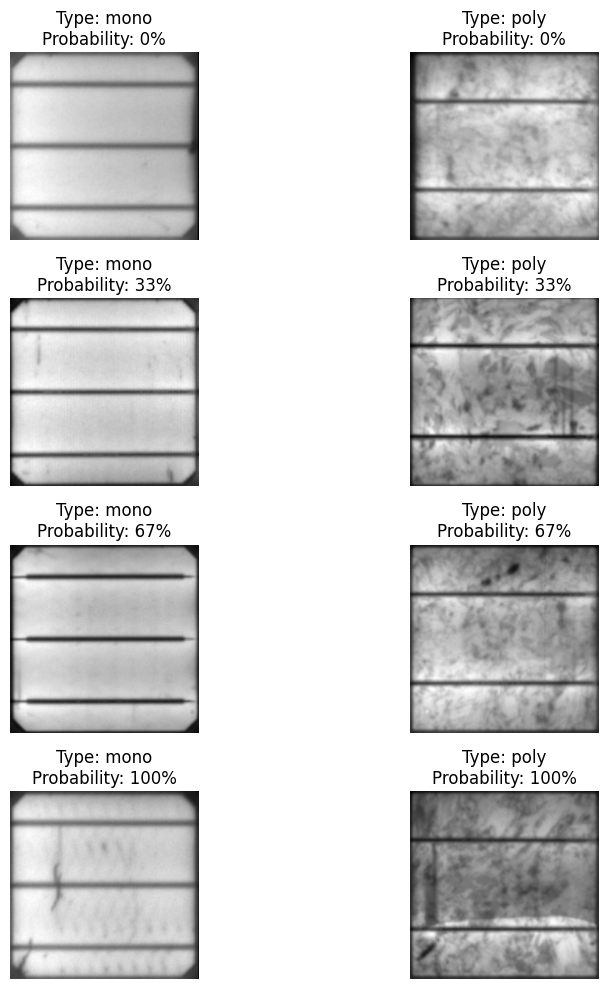

In [3]:
images, probs, types = load_dataset()
visualize_images_by_type_and_proba(images, probs, types)
metrics = dict()
model_name = "mobilenetv2"
load_objects = True ## this one makes sure that saved model weights are loaded for each model, switching this to False will start the training loop again for all the 3 cases of training

## Model trained on the solar cell image types of both mono and poly

In [4]:
(
    train_loader,
    val_loader,
    test_loader,
    train_dataset,
    val_dataset,
) = get_processed_data_loaders("both", load_data=load_objects)
solar_cell_detector_both = get_solar_cell_defect_detector(
    train_loader,
    val_loader,
    train_dataset,
    val_dataset,
    "data_both",
    load_weights=load_objects,
)
(
    metrics[("both", 224, "data")],
    correct_classification_both,
    incorrect_classification_both,
) = evaluate_detector_on_test_data(
    solar_cell_detector_both, test_loader, "data_both", load_results=load_objects
)

data loaders loaded
Weights loaded for model 1 from the file:  /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_both/model1/model_1_weights.pth
kmeans model loaded from :  /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_both/kmeans/kmeans.pkl
Model for cluster 0 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_both/model2/model2_cluster_0.pth
Model for cluster 1 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_both/model2/model2_cluster_1.pth
Model for cluster 2 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_both/model2/model2_cluster_2.pth
Model for cluster 3 loaded from /Users/fardeenmohammed/unsw

### Metrics for the model

Accuracy:  0.9068441064638784
F1 score:  0.9054460086609685
Confusion matrix: 


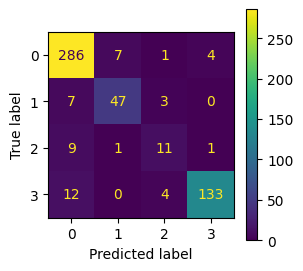

In [5]:
show_metrics(metrics[("both", 224, "data")])

### An example of correct classifcation by the model

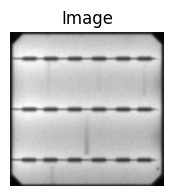

predicted class:  possibly defective (33% probability)
actual class:  possibly defective (33% probability)


In [6]:
show_image(correct_classification_both[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_both.detect_defect(correct_classification_both[0]))}\n" +
    f"actual class: {map_label_to_probability(correct_classification_both[1])}"
)

### An example of misclassifcation by the model

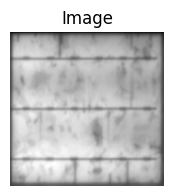

predicted class:  possibly defective (33% probability)
actual class: fully functional (0% probability of being defective)


In [7]:
show_image(incorrect_classification_both[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_both.detect_defect(incorrect_classification_both[0]))}\n" +
    f"actual class: {map_label_to_probability(incorrect_classification_both[1])}"
)

## Model being trained on solar cell images of type mono

In [8]:
(
    train_loader,
    val_loader,
    test_loader,
    train_dataset,
    val_dataset,
) = get_processed_data_loaders("mono", load_data=load_objects)
solar_cell_detector_mono = get_solar_cell_defect_detector(
    train_loader,
    val_loader,
    train_dataset,
    val_dataset,
    "data_mono",
    load_weights=load_objects,
)
(
    metrics[("mono", 224, "data")],
    correct_classification_mono,
    incorrect_classification_mono,
) = evaluate_detector_on_test_data(
    solar_cell_detector_mono, test_loader, "data_mono", load_results=load_objects
)

data loaders loaded
Weights loaded for model 1 from the file:  /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_mono/model1/model_1_weights.pth
kmeans model loaded from :  /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_mono/kmeans/kmeans.pkl
Model for cluster 0 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_mono/model2/model2_cluster_0.pth
Model for cluster 1 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_mono/model2/model2_cluster_1.pth
Model for cluster 2 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_mono/model2/model2_cluster_2.pth
Model for cluster 3 loaded from /Users/fardeenmohammed/unsw

### Metrics for the model

Accuracy:  0.9209302325581395
F1 score:  0.9198877735589329
Confusion matrix: 


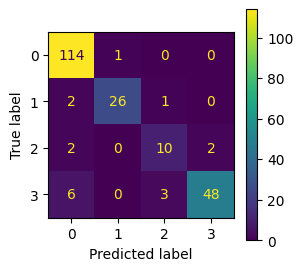

In [9]:
show_metrics(metrics[("mono", 224, "data")])

### An example of correct classifcation by the model

correct classification by the model: 


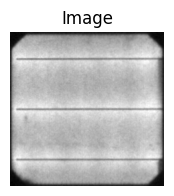

predicted class: fully functional (0% probability of being defective)
actual class: fully functional (0% probability of being defective)


In [10]:
print("correct classification by the model: ")
show_image(correct_classification_mono[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_mono.detect_defect(correct_classification_mono[0]))}\n" +
    f"actual class: {map_label_to_probability(correct_classification_mono[1])}"
)

### An example of misclassifcation by the model

misclassification by the model: 


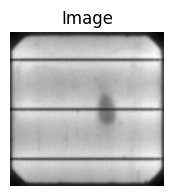

predicted class: likely defective (67% probability)
actual class: certainly defective (100% probability)


In [11]:
print("misclassification by the model: ")
show_image(incorrect_classification_mono[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_mono.detect_defect(incorrect_classification_mono[0]))}\n" +
    f"actual class: {map_label_to_probability(incorrect_classification_mono[1])}"
)

## Model being trained on solar cell images of type poly

In [12]:
(
    train_loader,
    val_loader,
    test_loader,
    train_dataset,
    val_dataset,
) = get_processed_data_loaders("poly", load_data=load_objects)
solar_cell_detector_poly = get_solar_cell_defect_detector(
    train_loader,
    val_loader,
    train_dataset,
    val_dataset,
    "data_poly",
    load_weights=load_objects,
)
(
    metrics[("poly", 224, "data")],
    correct_classification_poly,
    incorrect_classification_poly,
) = evaluate_detector_on_test_data(
    solar_cell_detector_poly, test_loader, "data_poly", load_results=load_objects
)

data loaders loaded
Weights loaded for model 1 from the file:  /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_poly/model1/model_1_weights.pth
kmeans model loaded from :  /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_poly/kmeans/kmeans.pkl
Model for cluster 0 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_poly/model2/model2_cluster_0.pth
Model for cluster 1 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_poly/model2/model2_cluster_1.pth
Model for cluster 2 loaded from /Users/fardeenmohammed/unsw/2023/term3/computer_vision/solarpanels/SolarPanel-EL-Analyzer/src/features/mobilenetv2/data_poly/model2/model2_cluster_2.pth
Model for cluster 3 loaded from /Users/fardeenmohammed/unsw

### Metrics for the model

Accuracy:  0.9228295819935691
F1 score:  0.9228281735516404
Confusion matrix: 


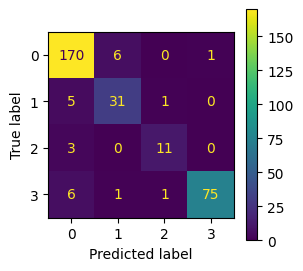

In [13]:
show_metrics(metrics[("poly", 224, "data")])

### An example of correct classifcation by the model

correct classification by the model: 


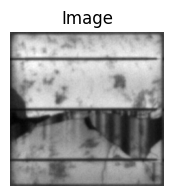

predicted class: certainly defective (100% probability)
actual class: certainly defective (100% probability)


In [14]:
print("correct classification by the model: ")
show_image(correct_classification_poly[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_poly.detect_defect(correct_classification_poly[0]))}\n" +
    f"actual class: {map_label_to_probability(correct_classification_poly[1])}"
)

### An example of misclassifcation by the model

misclassification by the model: 


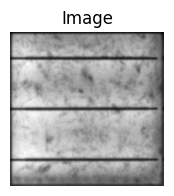

predicted class:  possibly defective (33% probability)
actual class: fully functional (0% probability of being defective)


In [15]:
print("misclassification by the model: ")
show_image(incorrect_classification_poly[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_poly.detect_defect(incorrect_classification_poly[0]))}\n" +
    f"actual class: {map_label_to_probability(incorrect_classification_poly[1])}"
)

## Comparision of Accuracy and F1 across this 3 training processes

__Accuracy__

<img src="plots/accuracy_mobilenetv2.png" width="1000" height="500">

__F1 score__

<img src="plots/f1_mobilenetv2.png" width="1000" height="500">

# EigenCell

### Load data

In [17]:
images, probs, types = load_dataset()

mono = Preprocess(data=(images, probs, types), type="mono")
mono_images, mono_probs = mono.get_preprocessed_data()

In [18]:
dimension = (128, 128, 1)
row, col, _ = dimension

In [19]:
mono_train_X, mono_test_X, mono_train_y, mono_test_y = train_test_split(
    mono_images, mono_probs, test_size=0.25, stratify=mono_probs, random_state=1
)

In [20]:
mono_eigen_model = EigenCell(
    (mono_train_X, mono_test_X, mono_train_y, mono_test_y), type="mono"
)
mono_eigen_model.fit()

OSError: [Errno 63] File name too long: '../../../data/pickles/(array([[0.07220105, 0.07220105, 0.07405694, ..., 0.04138178, 0.03814873,\n        0.03814873],\n       [0.23159601, 0.23159601, 0.23383061, ..., 0.29972198, 0.29867288,\n        0.29867288],\n       [0.21448423, 0.21448423, 0.21516483, ..., 0.11385847, 0.10724329,\n        0.10724329],\n       ...,\n       [0.01128248, 0.01030495, 0.00932672, ..., 0.01215935, 0.01064442,\n        0.01064442],\n       [0.03654727, 0.03654727, 0.03723026, ..., 0.01839776, 0.01796842,\n        0.01796842],\n       [0.05076821, 0.04479211, 0.04424882, ..., 0.06791277, 0.06450699,\n        0.06450699]]), array([[0.11782114, 0.11782114, 0.11784627, ..., 0.10444082, 0.09977664,\n        0.09977664],\n       [0.02560163, 0.02560163, 0.02560163, ..., 0.00598441, 0.00535328,\n        0.00535328],\n       [0.01943381, 0.01925354, 0.01925354, ..., 0.02128272, 0.02128272,\n        0.02134539],\n       ...,\n       [0.01911332, 0.01911332, 0.02105525, ..., 0.02250539, 0.01684447,\n        0.01684447],\n       [0.20389673, 0.20389673, 0.20601774, ..., 0.10758748, 0.09937468,\n        0.09937468],\n       [0.04778329, 0.04778329, 0.04753693, ..., 0.07683507, 0.07644385,\n        0.07644385]]), array([0.        , 0.        , 1.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 1.        , 0.        ,\n       0.33333333, 0.        , 1.        , 1.        , 0.33333333,\n       1.        , 1.        , 0.        , 1.        , 0.        ,\n       0.33333333, 0.        , 0.        , 0.        , 0.33333333,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 1.        , 1.        ,\n       0.66666667, 0.        , 0.        , 0.        , 0.        ,\n       0.66666667, 1.        , 0.33333333, 0.        , 0.33333333,\n       0.        , 0.        , 1.        , 0.        , 0.        ,\n       0.66666667, 1.        , 0.33333333, 0.        , 0.        ,\n       0.        , 0.        , 1.        , 1.        , 0.        ,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 1.        , 0.        , 0.        , 0.        ,\n       0.33333333, 0.        , 1.        , 0.        , 0.        ,\n       0.33333333, 1.        , 0.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 0.        , 0.        ,\n       0.        , 1.        , 0.        , 0.        , 1.        ,\n       0.33333333, 0.        , 0.        , 1.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.66666667, 0.        , 0.66666667, 1.        , 0.33333333,\n       1.        , 0.        , 0.        , 0.66666667, 0.        ,\n       0.33333333, 1.        , 1.        , 0.        , 0.        ,\n       0.        , 0.        , 1.        , 1.        , 0.        ,\n       0.        , 1.        , 0.        , 0.33333333, 0.        ,\n       0.        , 1.        , 0.        , 1.        , 0.        ,\n       1.        , 0.66666667, 0.        , 1.        , 1.        ,\n       1.        , 0.        , 1.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 0.        , 1.        ,\n       0.        , 0.        , 0.33333333, 0.        , 0.        ,\n       0.66666667, 0.        , 0.        , 0.        , 0.33333333,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.66666667, 0.        , 1.        , 0.        , 1.        ,\n       0.        , 1.        , 0.        , 0.66666667, 0.        ,\n       1.        , 0.66666667, 0.        , 0.        , 1.        ,\n       0.        , 0.        , 0.33333333, 0.33333333, 0.        ,\n       0.        , 0.66666667, 0.        , 0.        , 0.        ,\n       0.        , 0.        , 1.        , 1.        , 0.        ,\n       0.33333333, 0.        , 0.        , 0.66666667, 0.        ,\n       0.        , 0.        , 0.        , 0.33333333, 0.        ,\n       0.66666667, 0.66666667, 0.        , 1.        , 1.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 1.        , 0.        , 0.        , 0.        ,\n       1.        , 0.        , 0.        , 0.33333333, 1.        ,\n       1.        , 0.        , 1.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 1.        , 0.        ,\n       1.        , 0.        , 0.        , 1.        , 1.        ,\n       0.        , 0.        , 0.33333333, 0.33333333, 0.33333333,\n       0.        , 0.33333333, 1.        , 0.33333333, 1.        ,\n       0.        , 1.        , 0.33333333, 0.        , 1.        ,\n       0.        , 0.        , 0.        , 1.        , 0.66666667,\n       1.        , 1.        , 0.        , 1.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 1.        ,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.33333333, 1.        , 0.        ,\n       0.        , 1.        , 0.        , 0.        , 1.        ,\n       0.        , 0.        , 0.33333333, 0.66666667, 0.        ,\n       0.66666667, 1.        , 0.        , 1.        , 0.        ,\n       1.        , 0.        , 0.        , 1.        , 0.        ,\n       1.        , 0.66666667, 0.        , 0.        , 0.33333333,\n       0.        , 1.        , 0.        , 1.        , 0.        ,\n       0.        , 0.        , 0.33333333, 0.        , 0.        ,\n       0.        , 0.        , 0.33333333, 0.33333333, 0.        ,\n       0.33333333, 0.        , 1.        , 0.        , 0.        ,\n       0.        , 0.33333333, 1.        , 0.33333333, 0.        ,\n       1.        , 0.33333333, 0.        , 1.        , 0.66666667,\n       1.        , 0.        , 0.33333333, 0.33333333, 0.        ,\n       0.        , 0.        , 1.        , 1.        , 0.66666667,\n       1.        , 0.        , 0.33333333, 0.        , 0.        ,\n       0.        , 0.        , 1.        , 0.        , 1.        ,\n       0.        , 0.        , 0.        , 1.        , 0.66666667,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.        , 1.        , 1.        ,\n       1.        , 0.        , 1.        , 0.        , 0.33333333,\n       0.        , 0.66666667, 0.        , 0.33333333, 0.        ,\n       1.        , 0.        , 1.        , 0.        , 0.        ,\n       1.        , 1.        , 0.        , 0.        , 0.66666667,\n       1.        , 1.        , 1.        , 0.        , 1.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.33333333, 1.        , 0.        , 0.        , 0.        ,\n       0.        , 1.        , 1.        , 0.33333333, 0.        ,\n       0.        , 0.        , 0.        , 0.66666667, 0.33333333,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       0.33333333, 0.        , 0.        , 0.        , 0.66666667,\n       1.        , 0.33333333, 0.33333333, 1.        , 0.66666667,\n       1.        , 1.        , 1.        , 1.        , 1.        ,\n       0.        , 0.        , 0.33333333, 0.        , 0.        ,\n       0.33333333, 0.        , 0.        , 1.        , 0.        ,\n       0.        , 1.        , 0.33333333, 0.        , 0.66666667,\n       0.        , 1.        , 0.        , 1.        , 0.        ,\n       1.        , 0.        , 1.        , 0.        , 0.33333333,\n       1.        , 1.        , 0.        , 0.        , 0.        ,\n       0.        , 1.        , 0.        , 1.        , 0.        ,\n       0.        , 1.        , 1.        , 0.        , 0.        ,\n       0.33333333, 0.33333333, 0.        , 0.        , 0.        ,\n       1.        , 0.66666667, 1.        , 0.        , 0.        ,\n       0.66666667, 1.        , 0.66666667, 1.        , 0.66666667,\n       0.        , 1.        , 1.        , 0.        , 0.        ,\n       0.33333333, 1.        , 0.        , 0.        , 0.66666667,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       0.66666667, 0.        , 0.        , 0.        , 0.66666667,\n       0.        , 0.        , 0.        , 0.        , 1.        ,\n       1.        , 1.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 1.        , 0.        , 0.        ,\n       0.        , 0.        , 1.        , 1.        , 0.        ,\n       0.        , 0.        , 1.        , 0.        , 0.        ,\n       0.33333333, 1.        , 0.        , 1.        , 1.        ,\n       0.        , 1.        , 1.        , 0.        , 0.        ,\n       0.        , 1.        , 0.        , 0.        , 1.        ,\n       0.        , 0.33333333, 0.        , 1.        , 0.        ,\n       1.        , 0.        , 0.33333333, 1.        , 0.        ,\n       1.        , 0.33333333, 0.        , 1.        , 0.33333333,\n       0.33333333, 0.33333333, 1.        , 0.        , 0.        ,\n       1.        , 0.        , 0.        , 1.        , 0.        ,\n       1.        , 0.        , 0.        , 1.        , 0.66666667,\n       0.        , 1.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.33333333, 0.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 1.        ,\n       0.        , 0.33333333, 0.33333333, 0.        , 0.        ,\n       0.66666667, 1.        , 1.        , 0.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       1.        , 1.        , 1.        , 0.        , 1.        ,\n       0.        , 1.        , 1.        , 1.        , 0.        ,\n       0.        , 1.        , 0.        , 0.33333333, 0.        ,\n       0.        , 1.        , 1.        , 0.33333333, 0.33333333,\n       1.        , 0.33333333, 0.        , 1.        , 1.        ,\n       1.        , 0.33333333, 1.        , 0.33333333, 0.        ,\n       0.        , 0.        , 0.        , 0.        , 1.        ,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 0.33333333, 1.        ,\n       0.        , 0.33333333, 0.        , 1.        , 0.33333333,\n       0.66666667, 0.        , 1.        , 0.66666667, 1.        ,\n       0.        , 1.        , 0.        , 0.        , 0.33333333,\n       0.        , 0.        , 0.        , 0.        , 0.33333333,\n       0.        , 0.        , 0.        , 1.        , 1.        ,\n       0.66666667, 1.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 1.        , 0.        ,\n       0.66666667, 1.        , 0.        , 1.        , 0.66666667,\n       1.        , 0.        , 0.        , 0.        , 0.33333333,\n       0.33333333, 1.        , 1.        , 0.33333333, 0.        ,\n       0.        , 0.33333333, 0.        , 0.33333333, 1.        ,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       1.        , 0.33333333, 0.        , 0.        , 0.        ,\n       0.        , 1.        , 0.        , 0.        , 1.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       1.        , 1.        , 0.33333333, 0.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 1.        ,\n       0.33333333, 1.        , 0.        , 1.        , 0.        ,\n       1.        , 0.        , 0.33333333, 0.        , 1.        ,\n       1.        , 1.        , 0.        , 0.        , 0.        ,\n       1.        , 1.        , 0.33333333, 0.        , 1.        ,\n       1.        , 1.        , 1.        , 1.        , 0.33333333,\n       1.        , 1.        , 1.        , 0.        , 1.        ,\n       0.33333333, 0.        , 1.        , 0.33333333, 0.        ,\n       0.        , 1.        , 0.        , 1.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       1.        , 1.        , 0.        , 0.        , 1.        ]), array([1.        , 1.        , 0.        , 0.66666667, 0.        ,\n       1.        , 0.66666667, 1.        , 0.        , 0.        ,\n       1.        , 0.33333333, 0.        , 1.        , 1.        ,\n       0.33333333, 0.        , 0.        , 0.        , 1.        ,\n       1.        , 0.66666667, 0.        , 0.33333333, 0.        ,\n       0.33333333, 0.66666667, 1.        , 0.        , 0.        ,\n       0.        , 0.        , 0.33333333, 0.        , 1.        ,\n       0.        , 0.        , 1.        , 0.        , 1.        ,\n       1.        , 0.33333333, 0.        , 0.33333333, 0.        ,\n       0.        , 0.33333333, 0.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 0.        , 0.33333333,\n       0.        , 0.        , 0.        , 0.        , 0.33333333,\n       0.        , 0.        , 0.33333333, 0.        , 0.        ,\n       0.        , 0.        , 0.66666667, 0.33333333, 1.        ,\n       0.66666667, 0.        , 1.        , 1.        , 1.        ,\n       1.        , 0.        , 1.        , 1.        , 0.        ,\n       1.        , 1.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.        , 1.        , 0.        ,\n       0.        , 0.        , 1.        , 1.        , 1.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 1.        ,\n       1.        , 0.66666667, 1.        , 0.        , 0.33333333,\n       1.        , 0.        , 0.        , 0.        , 1.        ,\n       0.        , 0.        , 0.        , 1.        , 0.33333333,\n       0.        , 1.        , 0.        , 1.        , 1.        ,\n       0.33333333, 0.        , 0.        , 1.        , 0.33333333,\n       0.        , 0.33333333, 1.        , 1.        , 0.66666667,\n       1.        , 0.        , 1.        , 0.        , 0.        ,\n       0.        , 1.        , 0.        , 1.        , 0.33333333,\n       0.        , 0.        , 0.        , 1.        , 0.66666667,\n       0.        , 0.        , 1.        , 0.        , 0.        ,\n       1.        , 0.66666667, 1.        , 1.        , 0.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 1.        , 0.        , 0.        ,\n       1.        , 0.        , 1.        , 1.        , 0.        ,\n       1.        , 0.        , 0.        , 0.33333333, 0.        ,\n       0.        , 0.        , 0.        , 0.        , 0.        ,\n       0.33333333, 0.33333333, 0.        , 0.        , 0.        ,\n       0.33333333, 1.        , 1.        , 1.        , 0.        ,\n       1.        , 1.        , 1.        , 1.        , 0.33333333,\n       0.        , 0.33333333, 0.        , 0.        , 1.        ,\n       1.        , 0.        , 0.66666667, 0.        , 0.33333333,\n       0.        , 0.        , 1.        , 1.        , 0.        ,\n       0.33333333, 1.        , 1.        , 0.        , 0.        ,\n       0.        , 0.        , 1.        , 0.        , 0.        ,\n       1.        , 0.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 0.        , 1.        , 1.        ,\n       0.66666667, 0.        , 0.        , 0.        , 0.        ,\n       0.        , 0.        , 1.        , 0.        , 0.66666667,\n       1.        , 0.33333333, 0.        , 1.        , 1.        ,\n       0.        , 1.        , 0.        , 0.66666667, 0.        ,\n       0.        , 0.        , 0.        , 1.        , 0.33333333,\n       1.        , 0.        , 0.        , 0.        , 0.33333333,\n       0.        , 0.        , 0.        , 0.        ]))_mono_split.pkl'

**First Eigen Cell**

In [ ]:
plt.imshow(mono.C[:0].reshape(dimension), cmap="gray")